In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline

import tyssue as ty
from tyssue.core import Epithelium, Cell, JunctionEdge, JunctionVertex
from tyssue.core.generation import three_cells_sheet
from tyssue.geometry import sheet_geometry as geom

In [2]:
cell_df, jv_df, je_df = three_cells_sheet()

eptm = Epithelium('3cells_2D', cell_df, jv_df, je_df)
cell = Cell(eptm, 0)
jv = JunctionVertex(eptm, 0)
je = JunctionEdge(eptm, (0, 1, 0))
cell.jv_orbit()

geom.update_all(eptm)

## Matplotlib based

### Custom settings

These might go in a config file latter on.

In [3]:
edge_arrow_style = {'width':0.01,
                    'length_includes_head':True,
                    'shape':'right',
                    'color':'#2b5d0a',
                    'alpha':0.8,
                    'zorder':1}

points_style = {'s':100,
                'c':'#000a4b',
                'alpha':0.3,
                'zorder':2}

coords = ['x', 'y']

#### Ploting itself

In [4]:
def plt_eptm(eptm, coords, edge_arrow_style, points_style):

    fig, ax = plt.subplots()
    try:
        dcoords = ['d'+c for c in coords]
        x, y = coords
        dx, dy = dcoords
    except (ValueError, TypeError):
        raise ValueError('The `coords` argument must be'
                         ' a pair of column names')
    
    ax.scatter(eptm.jv_df[x], eptm.jv_df[y], **points_style)

    for e in eptm.je_idx:
        s, t, c = e
        ax.arrow(eptm.jv_df[x].loc[s], eptm.jv_df[y].loc[s],
                 eptm.je_df[dx].loc[e], eptm.je_df[dy].loc[e],
                 **edge_arrow_style)

    ax.set_aspect('equal')
    ax.grid()
    return fig, ax
    

#### Default plot

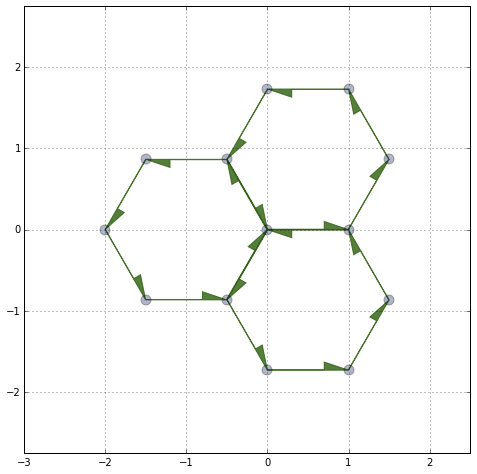

In [5]:
fig, ax = plt_eptm(eptm, ['x', 'y'],
                   edge_arrow_style,
                   points_style)


ax.set_xlim(-3, 2.5)
ax.set_ylim(-2.75, 2.75)
fig.set_size_inches((8, 8))
    


#### Coloring

In [6]:
new_pt_style = points_style.copy()

## Let's add a column to eptm.jv_df
eptm.jv_df['rand'] = np.random.normal(loc=0.5, scale=0.4, 
                                      size=eptm.jv_df.shape[0])

cmap = plt.cm.get_cmap('PRGn')
color_cmap = cmap(eptm.jv_df.rand)

new_pt_style['color'] = color_cmap
new_pt_style['alpha'] = 1
new_pt_style['s'] = 200

### TODO: doing the same to change the edge's style is less
### trivial, as you have to cycle through the color sequence
### within the `for e in eptm.je_idx` loop...

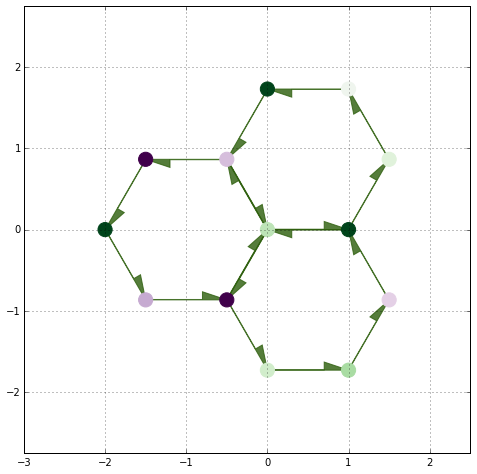

In [7]:
fig, ax = plt_eptm(eptm, coords, edge_arrow_style, new_pt_style)

ax.set_xlim(-3, 2.5)
ax.set_ylim(-2.75, 2.75)
fig.set_size_inches((8, 8))

#### Filling the cells



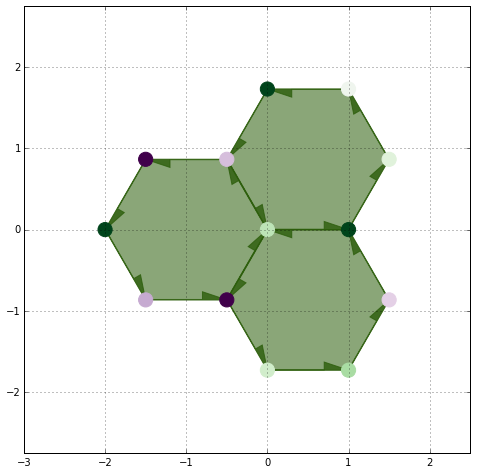

In [8]:
from matplotlib.patches import Polygon

coords = ['x', 'y']
x, y = coords

cell_colors = None
alphas = None
cell_style = {'color':'#8aa678',
              'alpha':1,
              'zorder':-1}


for c_idx in eptm.cell_idx:
    
    cell = Cell(eptm, c_idx)
    poly = eptm.jv_df[coords].loc[cell.jv_orbit()]
    patch = Polygon(poly,
                    fill=True,
                    closed=True,
                    **cell_style)
    ax.add_patch(patch)
    
    
fig

### Vispy based


In [9]:
coords = ['x', 'y', 'z']
eptm.jv_df['z'] = 1.
geom.update_all(eptm)

vertices, faces, cell_mask = eptm.triangular_mesh(coords)

In [10]:
import vispy as vp
import sys
import IPython

from IPython import display

from vispy import app, gloo, visuals, scene
from vispy.geometry import MeshData
#from vispy import plot
#vp.use('PyQt4')

from vispy.app.backends.ipython import VispyWidget

print('VisPy version: {}'.format(vp.__version__))


print('Python version: {}'.format(sys.version))
print('Jupyter version: {}'.format(IPython.__version__))

VisPy version: 0.5.0.dev0
Python version: 3.4.3 |Anaconda 2.3.0 (64-bit)| (default, Jun  4 2015, 15:29:08) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Jupyter version: 4.0.0


/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [11]:
cell_color = vp.color.ColorArray(cell_style['color'], alpha=0.8)

In [15]:
!ls ../leg_joint\ import

before_apoptosis.hf5  Import data from leg-joint.ipynb	nb_init.py


In [ ]:
with pd.get_store('../leg_joint import/before_apoptosis.hf5') as store:
    cell_df = store.get('cell_df')
    jv_df = store.get('jv_df')
    je_df = store.get('je_df')
    
eptm = Epithelium('before', cell_df, jv_df, je_df)
vertices, faces, cell_mask = eptm.triangular_mesh(coords)

In [23]:

canvas = scene.SceneCanvas(keys='interactive', show=True)

grid = canvas.central_widget.add_grid()
view = grid.add_view(0, 1)
#view = canvas.central_widget.add_view()
view.camera =  'turntable'
view.camera.aspect = 1

cell_color = vp.color.ColorArray(cell_style['color'], alpha=0.5)
cell_color = cell_color.rgba.repeat(eptm.Nf, axis=0)

edge_color = vp.color.ColorArray(edge_arrow_style['color'], alpha=1)

view.bgcolor = vp.color.Color('#ffffff')


mesh = vp.scene.visuals.Mesh(vertices=vertices,
                             faces=faces,
                             face_colors=cell_color)

wire_pos = vertices[eptm.Nc:].copy()
wire_pos[:, 2] += 0.1

wire = vp.scene.visuals.Line(pos=wire_pos, 
                             connect=faces[:, :2]-eptm.Nc,
                             color=edge_color,
                             width=20)

view.add(mesh)
view.add(wire)
view.camera.set_range()
canvas.show()

#vp_widget = VispyWidget()
#vp_widget.set_canvas(canvas)



app.run()

0